In [ ]:
!pip install --upgrade gensim
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [ ]:
#散点图和密度图
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [ ]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

数据处理

列Healthy_Status：0=患者，1-条件健康。

In [ ]:
#上传完整数据集
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
#将word2vec口头报告中的数据预处理为数字向量
#消除排放
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]
words = [text.split() for text in full_df_filtered['report']]
w2v_model = Word2Vec(words)
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())
#从旧列创建新数据集
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()

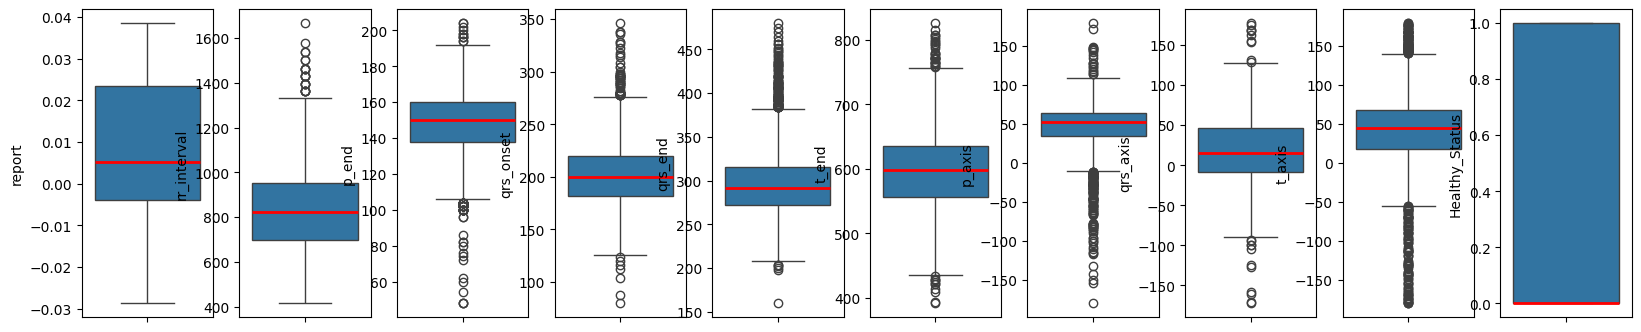

In [ ]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

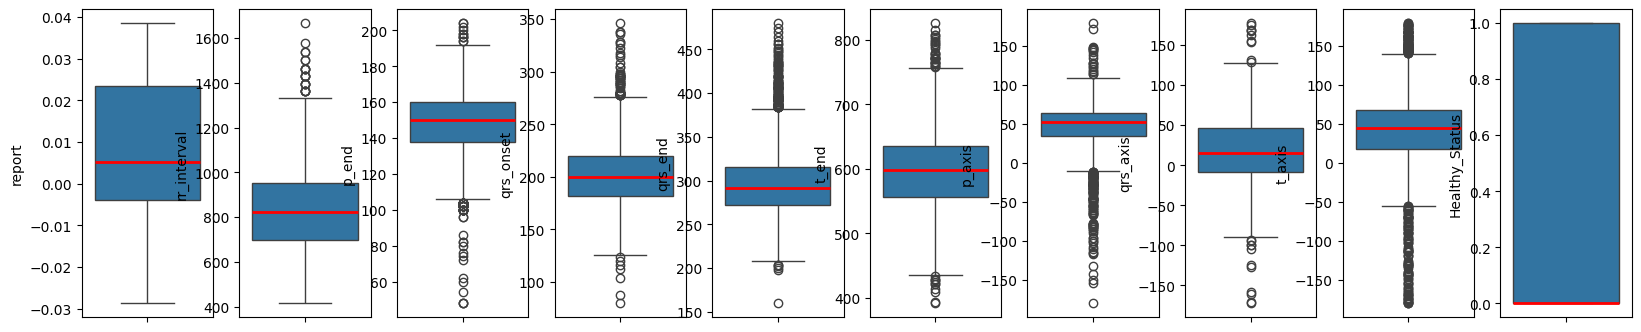

In [ ]:
#从数据中删除异常（删除超过5000的所有值）
for i, v in enumerate(table_data):
  table_data = table_data.drop(table_data[table_data.iloc[:,i] > 10000].index)
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data,
                medianprops={"color": "r", "linewidth": 2})
    plt.tight_layout

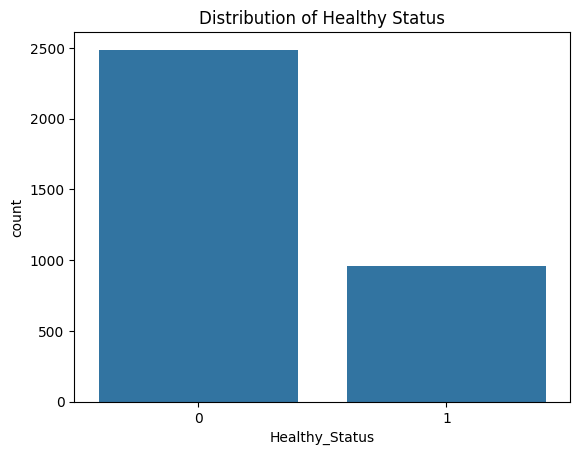

In [ ]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

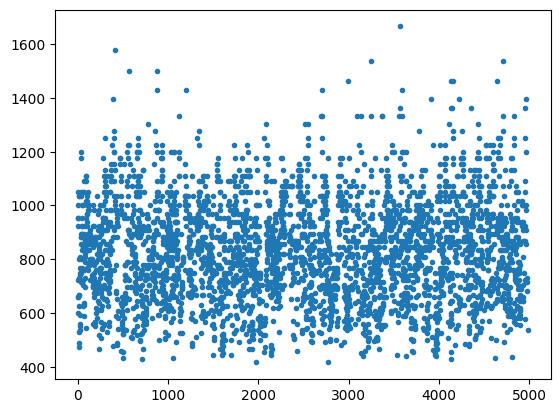

In [ ]:
plt.plot(table_data['rr_interval'],'.')

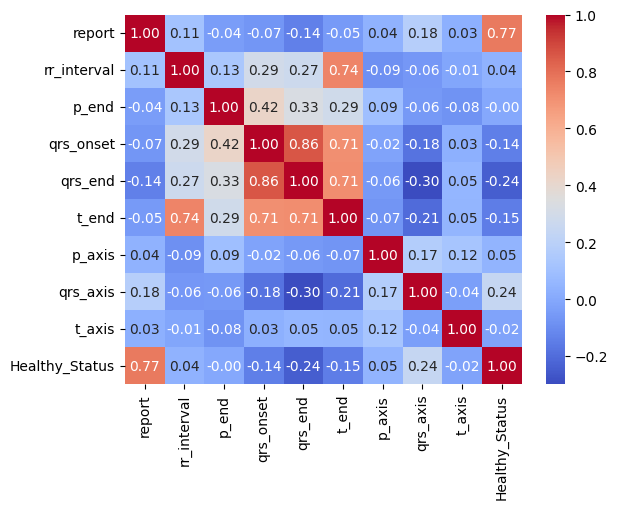

In [ ]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

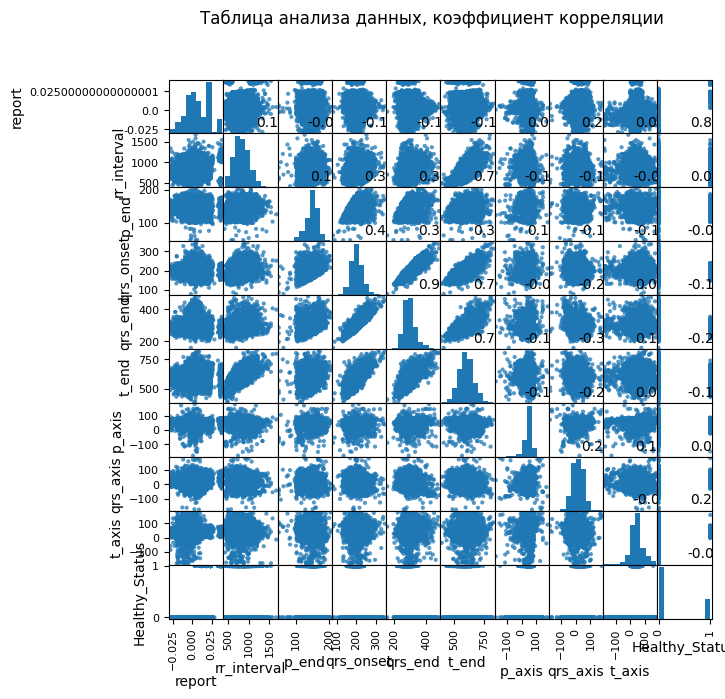

In [ ]:
plotScatterMatrix(table_data, 7, 10)

<Axes: xlabel='rr_interval', ylabel='p_axis'>

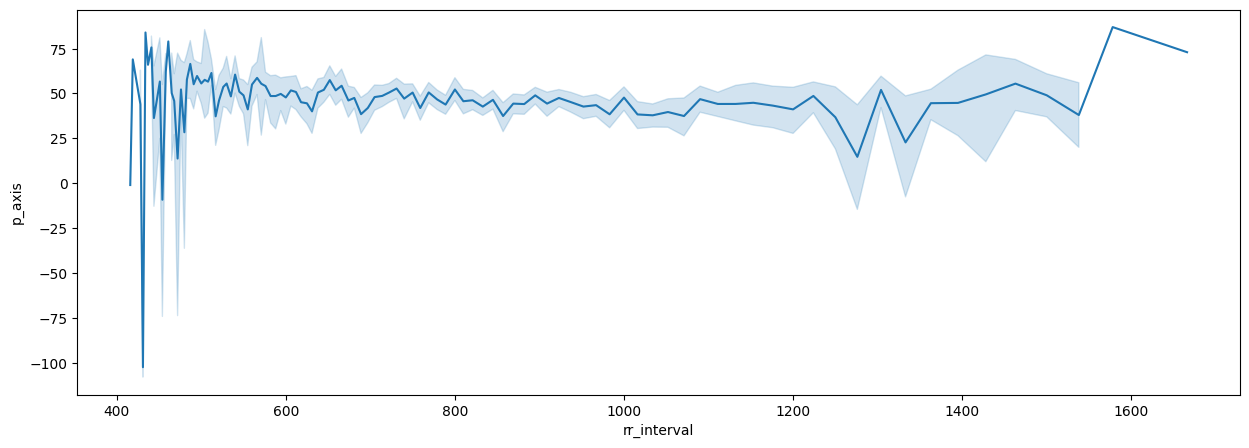

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
#sns.lineplot(x='age',y='debtinc',data=table_data,ax=ax)
sns.lineplot(x='rr_interval',y='p_axis',data=table_data,ax=ax)

<Axes: xlabel='rr_interval', ylabel='qrs_end'>

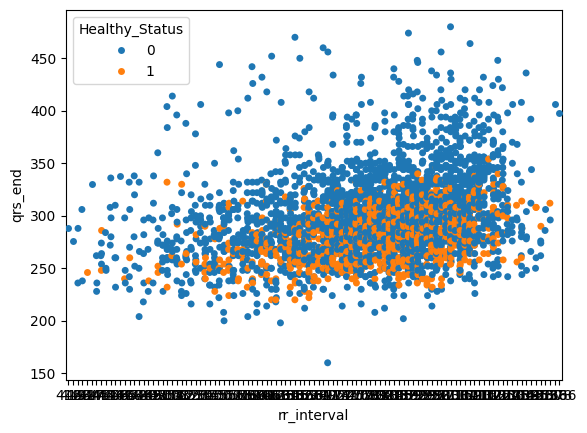

In [ ]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['qrs_end'],
              hue=table_data['Healthy_Status'],jitter=True)

<Axes: xlabel='rr_interval'>

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


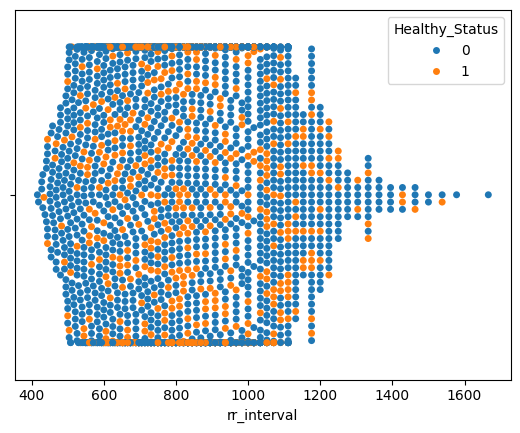

In [ ]:
sns.swarmplot(data=table_data, x="rr_interval", hue="Healthy_Status")

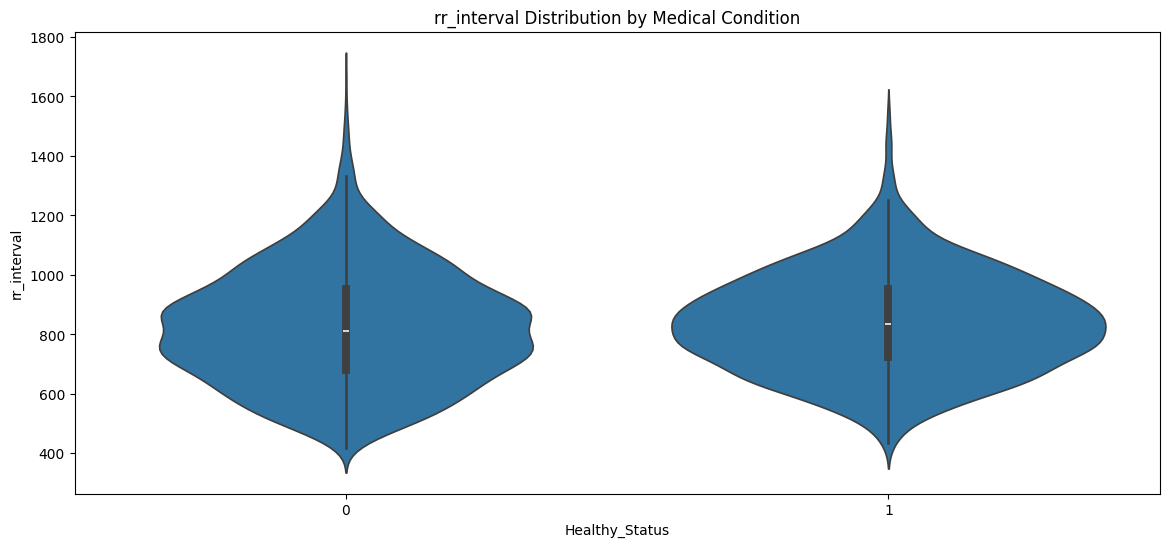

In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=table_data, y='rr_interval', x='Healthy_Status')
plt.title('rr_interval Distribution by Medical Condition')
plt.show()

PCA

(3448, 10) (3448, 2)
[0.34492145 0.14045853]
0.48537997454663945
2 components at 48.54% explained variance
3 components at 61.53% explained variance
4 components at 73.33% explained variance
5 components at 82.33% explained variance
6 components at 90.30% explained variance


Text(0, 0.5, 'Second Principal Component')

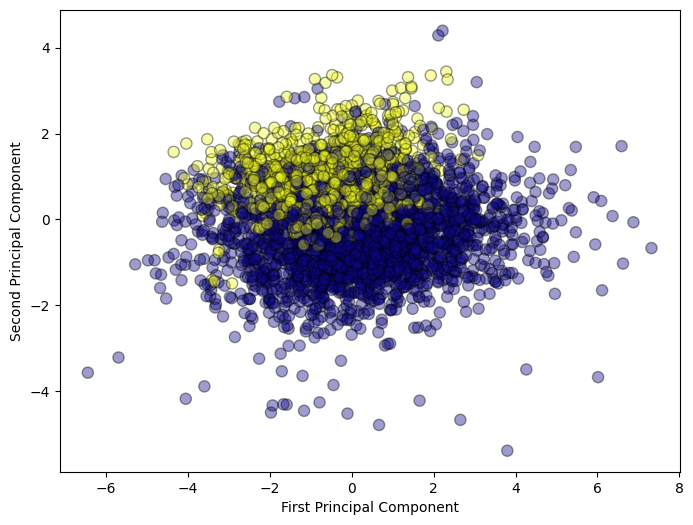

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns
##在应用PCA之前，应输入每个特征（零均值）并具有单位方差
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#查看每个数据集保留了多少方差。
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<ipython-input-25-3c3db0dc0e34>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
<ipython-input-25-3c3db0dc0e34>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')


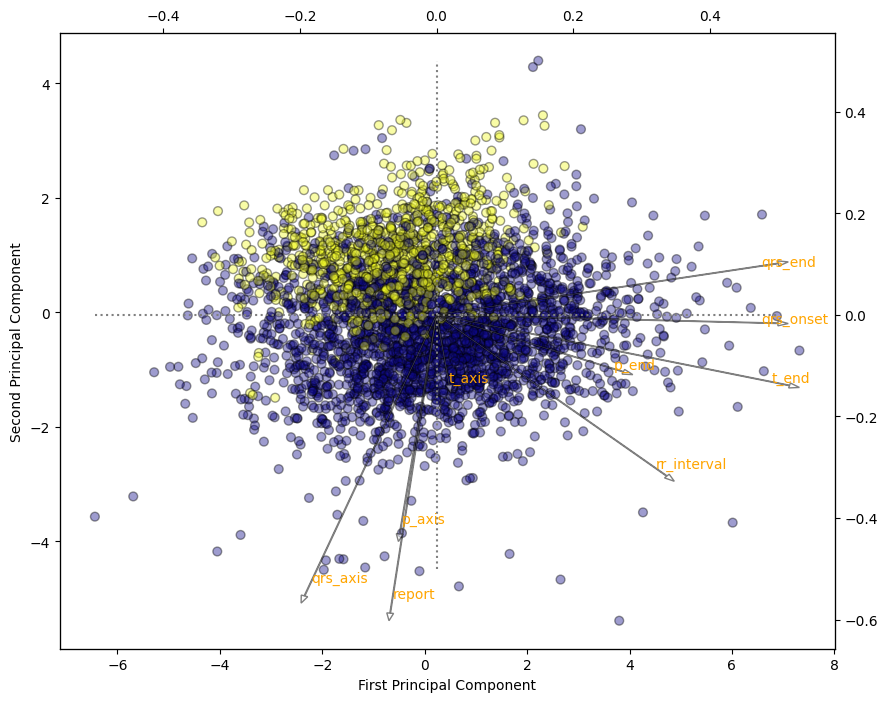

In [ ]:
#将特征值放入数据框
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
plt.figure(figsize=(10,8))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
ax2 = plt.twinx().twiny();
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
offset = 0.95
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

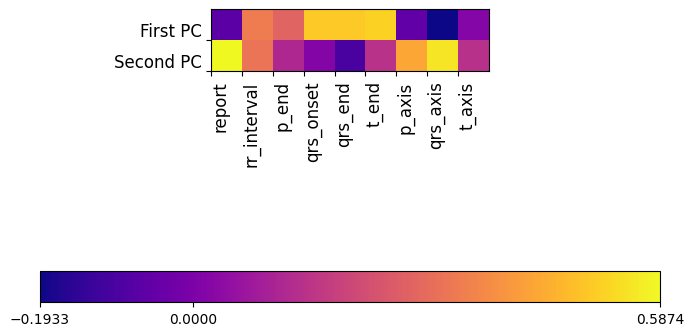

In [ ]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, pca.components_.max()],pad=0.65);

ML

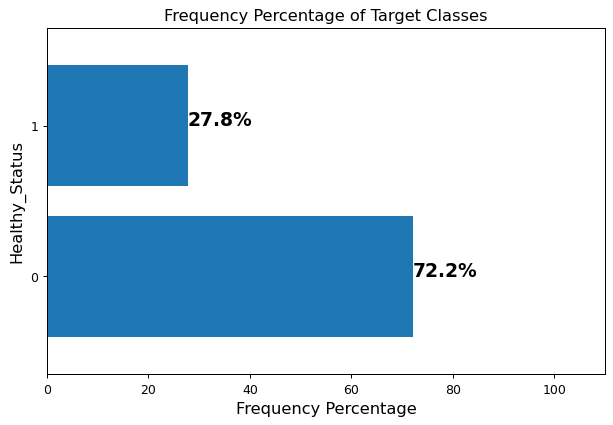

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
table_data.columns
clf_index = 9
plt.figure(figsize=(35,20),dpi=90)
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')
plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [ ]:
y1 = table_data.iloc[:, clf_index]
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values, y1.values, test_size=0.3, random_state=0, stratify=y1.values)
X_train,X_test,y_train,y_test = train_test_split(X1.values, y1.values, test_size=0.3, random_state=41, stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))

X_train shape: (2413, 9)
y_train shape: (2413,)
X_test shape: (1035, 9)
y_test shape: (1035,)
Accuracy                     =  0.9391304347826087
F1 Score                     =  0.8982229402261712


              precision    recall  f1-score   support

        True       0.99      0.93      0.96       747
       False       0.84      0.97      0.90       288

    accuracy                           0.94      1035
   macro avg       0.91      0.95      0.93      1035
weighted avg       0.95      0.94      0.94      1035



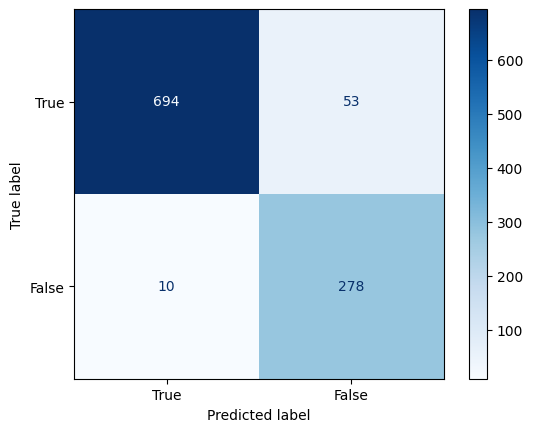

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

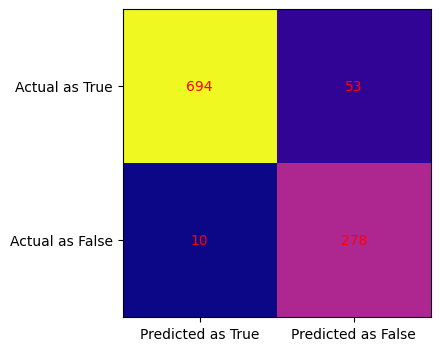

In [ ]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))
fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

AutoML

In [ ]:
#从数据集中删除额外的列
#为Automnl方法创建数据集
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

AutoML H2O

In [ ]:
!pip install h2o
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
h2o.init()
h2o_df = H2OFrame(autoML_df)
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
automl.train(x=x, y=y, training_frame=train)
performance = automl.leader.model_performance(test_data=test)
print(performance)
lb = automl.leaderboard
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
lb.head()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1yy2uirx
  JVM stdout: /tmp/tmp1yy2uirx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1yy2uirx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_8c2mvn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:28:32.626: Project: AutoML_1_20250513_212832
21:28:32.636: 5-fold cross-validation will be used.
21:28:32.644: Setting stopping tolerance adaptively based on the training frame: 0.018464772811525407
21:28:32.645: Build control seed: 17
21:28:32.646: training frame: Frame key: AutoML_1_20250513_212832_training_py_19_sid_a719    cols: 10    rows: 2933  chunks: 1    size: 68508  checksum: 610842416762585971
21:28:32.646: validation frame: NULL
21:28:32.646: leaderboard frame: NULL
21:28:32.646: blending frame: NULL
21:28:32.647: response column: Healthy_Status
21:28:32.647: fold column: null
21:28:32.647: weights column: null
21:28:32.728: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_2_AutoML_1_20250513_212832,0.106698,0.0113844,0.0379116,0.0755144,0.0113844
StackedEnsemble_BestOfFamily_3_AutoML_1_20250513_212832,0.1067,0.0113848,0.0377994,0.0755208,0.0113848
StackedEnsemble_AllModels_1_AutoML_1_20250513_212832,0.107043,0.0114583,0.0390774,0.0757775,0.0114583
GBM_3_AutoML_1_20250513_212832,0.107582,0.0115738,0.0385385,0.076059,0.0115738
GBM_2_AutoML_1_20250513_212832,0.115671,0.0133799,0.0556966,0.0818197,0.0133799
StackedEnsemble_BestOfFamily_1_AutoML_1_20250513_212832,0.117511,0.0138088,0.0551907,0.0843854,0.0138088
GBM_4_AutoML_1_20250513_212832,0.119023,0.0141664,0.0594705,0.0855658,0.0141664
XGBoost_1_AutoML_1_20250513_212832,0.119397,0.0142556,0.0609468,0.0868079,0.0142556
DRF_1_AutoML_1_20250513_212832,0.12668,0.0160478,0.0377772,0.089225,0.0160478
GBM_1_AutoML_1_20250513_212832,0.133485,0.0178182,0.0565991,0.0945095,0.0178182


In [ ]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.convert_H2OXGBoostParams_2_XGBoostParams()
automl.leader.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.004672841240102669
RMSE: 0.06835818341722276
MAE: 0.026540932216810517
RMSLE: 0.04793288944447142
Mean Residual Deviance: 0.004672841240102669
R^2: 0.9745773473250005
Null degrees of freedom: 514
Residual degrees of freedom: 512
Null deviance: 95.56748634029051
Residual deviance: 2.4065132386528747
AIC: -1293.977125500649

In [ ]:
test_predict = automl.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


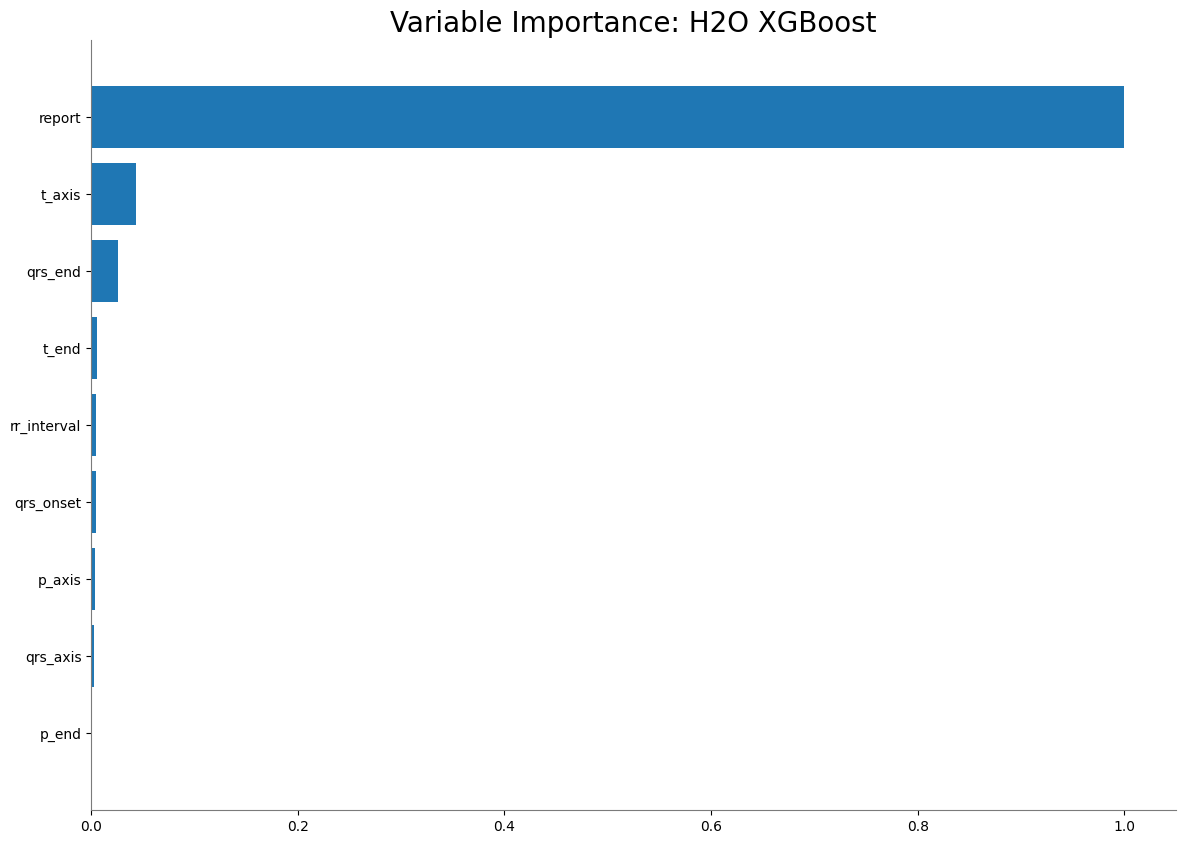

<Figure size 640x480 with 0 Axes>

In [ ]:
out.varimp_plot()

In [ ]:
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0
cm = confusion_matrix(test_Y, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(test_Y, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Confusion matrix: [[390   0]
 [  2 123]]
F1-Score:  0.99
Accuracy: 1.00
Recall:  0.98
Precision:  1.00


In [ ]:
h2o.shutdown()

H2O session _sid_a719 closed.


<ipython-input-62-1edf85295eae>:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


AutoML BlueCast


In [ ]:
!pip install bluecast --quiet
import numpy as np
import pandas as pd
import re
from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()
autoML_df = autoML_df.drop(columns='report')
random_seed = 13
clf_index = autoML_df.shape[1]-1
auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 40.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3transfer 0.12.0 requires botocore<2.0a.0,>=1.37.4, but you have botocore 1.37.3 which is incompatible.
boto3 1.38.15 requires botocore<1.39.0,>=1.38.15, but you have botocore 1.37.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
seed = 13
table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
df = table_data
target = 'Healthy_Status'
train_dataset = autoML_df.sample(frac=.8, random_state=seed)
test_dataset = autoML_df.drop(train_dataset.index)
full_df = df
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = full_df[(full_df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]
full_df_filtered.head()
full_df_filtered['report']

,report
0,Sinus rhythm Possible right atrial abnormality...
1,Sinus rhythm Possible right atrial abnormality...
2,Sinus tachycardia Normal ECG except for rate
3,Sinus rhythm Normal ECG
6,Sinus rhythm Normal ECG
...,...
4967,Sinus rhythm Anterior T wave changes are nonsp...
4969,Sinus rhythm Possible left atrial abnormality ...
4970,Sinus rhythm Possible left atrial abnormality ...
4971,Sinus rhythm Possible left atrial abnormality ...


In [ ]:
from bluecast.preprocessing.feature_types import FeatureTypeDetector

feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train_dataset)

len(feat_type_detector.num_columns)
print(feat_type_detector.date_columns)
feat_type_detector.num_columns

[]


['rr_interval',
 'p_end',
 'qrs_onset',
 'qrs_end',
 't_end',
 'p_axis',
 'qrs_axis',
 't_axis',
 'Healthy_Status']

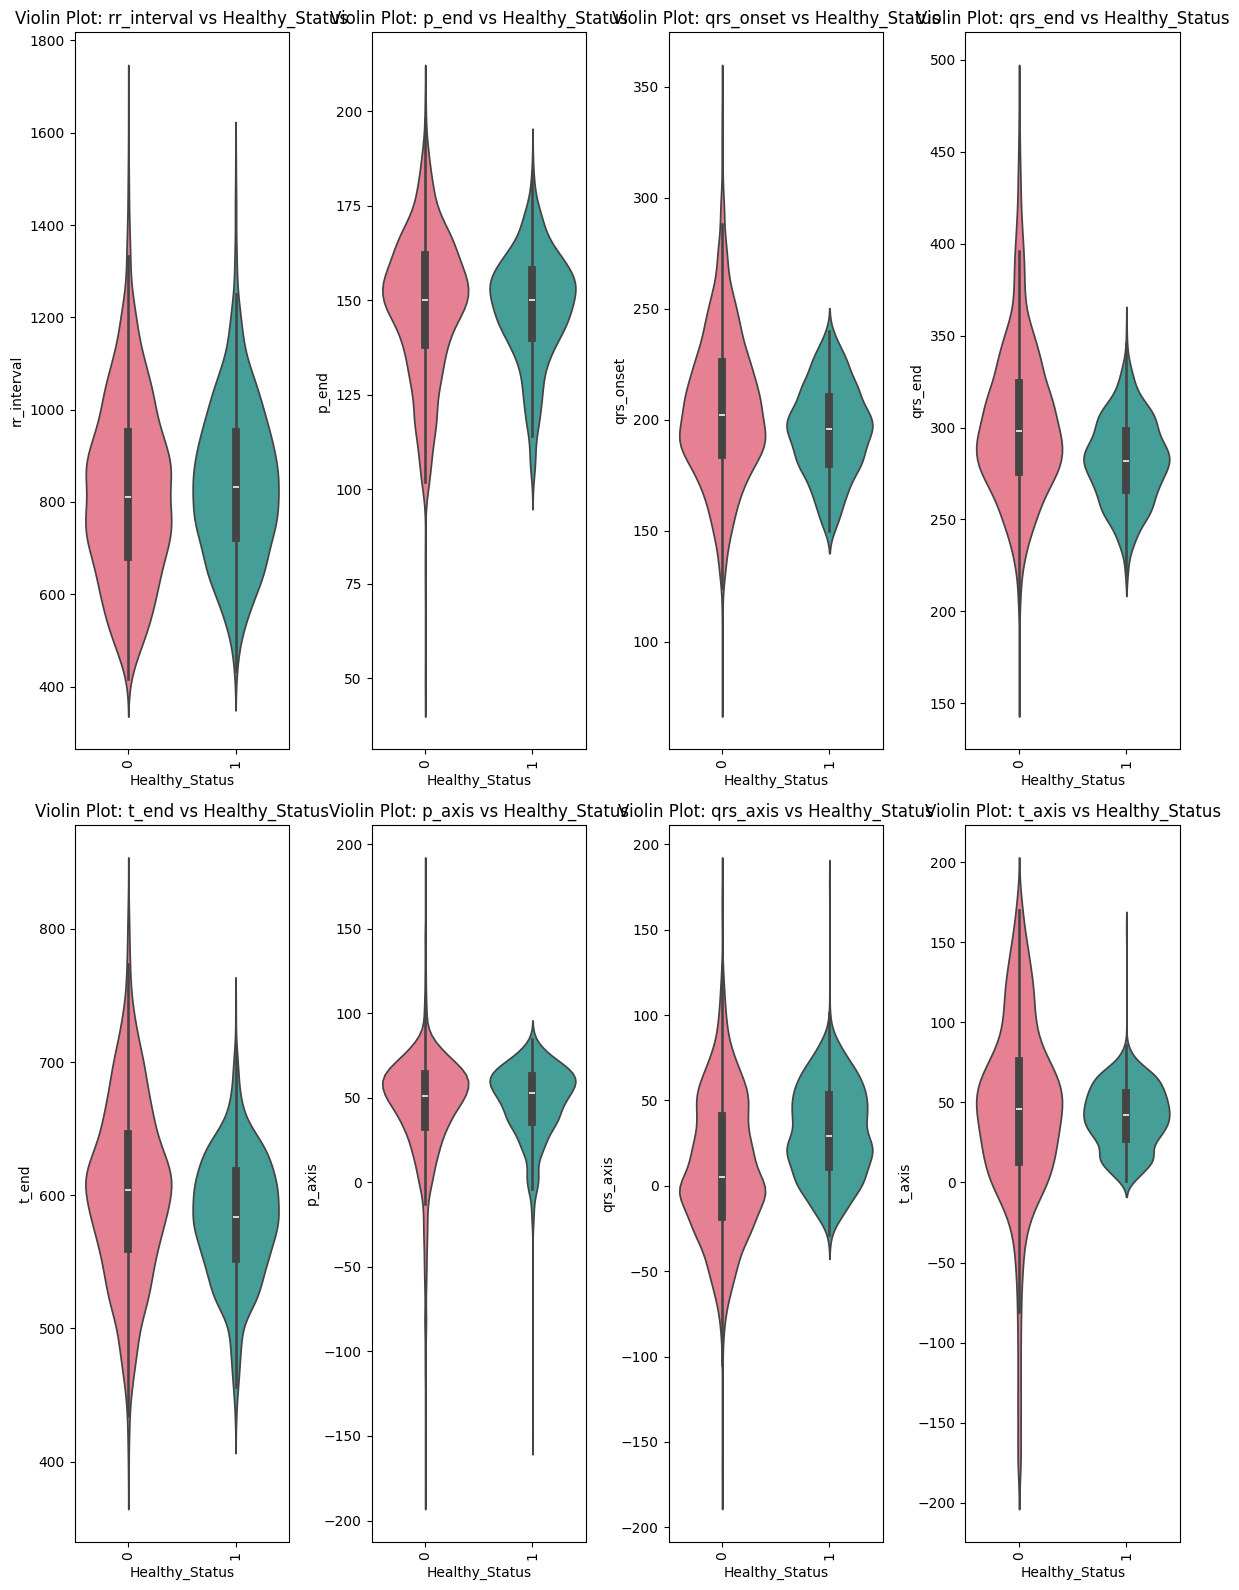

In [ ]:
from bluecast.eda.analyse import (
    bi_variate_plots,
    correlation_heatmap,
    correlation_to_target,
    plot_pca,
    plot_theil_u_heatmap,
    plot_tsne,
    univariate_plots,
    check_unique_values,
    plot_null_percentage
)
bi_variate_plots(
        full_df_filtered.loc[
            :, feat_type_detector.num_columns
        ],
        target,
    )

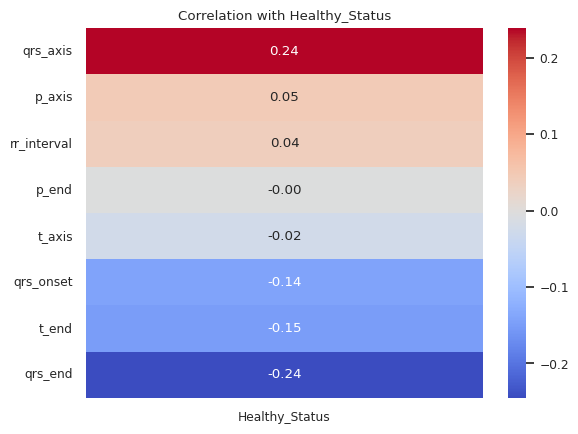

In [ ]:
correlation_to_target(
    full_df_filtered.loc[:, feat_type_detector.num_columns],
      target,
      )

In [ ]:
no_correlation = ["p_onset", "subject_id", "p_end", "cart_id", "Count_subj"]

train = full_df_filtered.drop(no_correlation, axis=1)
test = full_df_filtered.drop(no_correlation, axis=1)

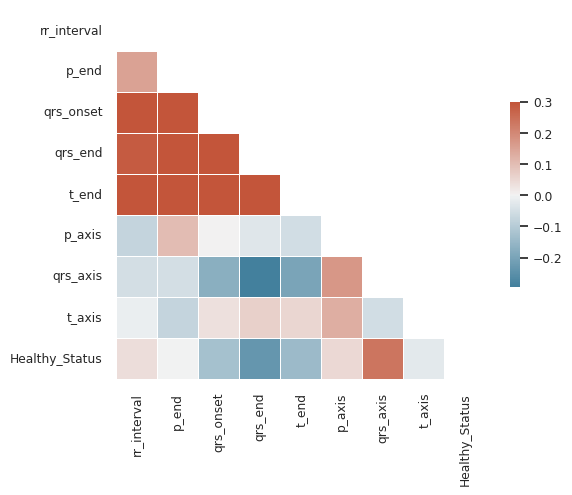

In [ ]:
correlation_heatmap(train_data.loc[
            :, train_data.columns.values])

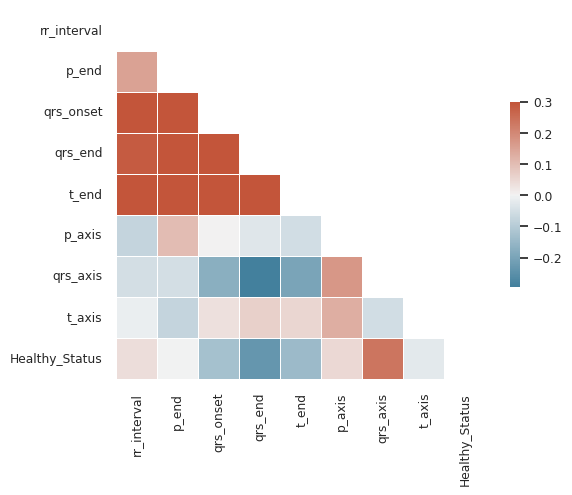

In [ ]:
correlation_heatmap(train_data.loc[
            :, feat_type_detector.num_columns])

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 -1.56341374]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
 -0.01246899]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  0.52348467]' has dtype incompatible with int64, please explicitly c

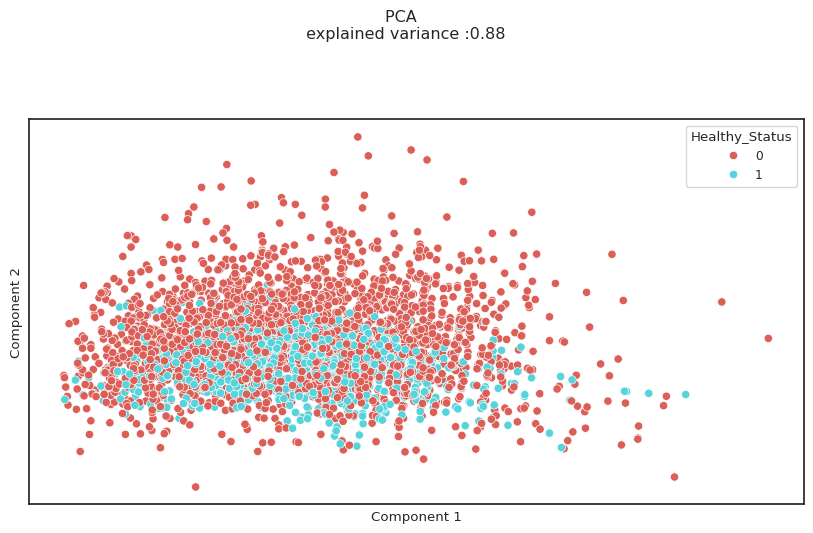

In [ ]:
plot_pca(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].fillna(0), target)

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 -0.03309216  0.22290971 -0.65481098  0.15499084  0.09229651  0.15499084
 -0.65481098  0.02960217 -1.71016561 -2.13335237 -0.61301475  0.09229651
  1.52904168  0.75058702 -1.0518751  -0.03309216  1.01703794  0.29082857
 -0.97873171  1.01703794 -0.97873171 -0.565994    0.83

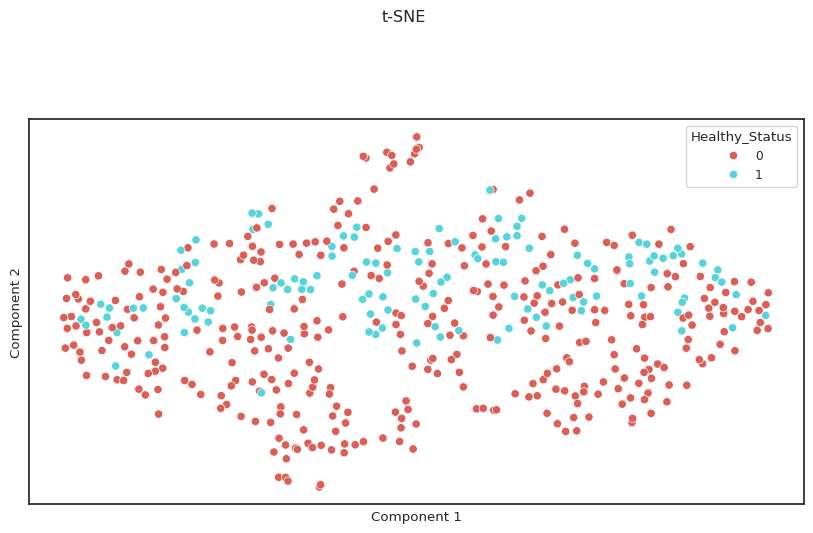

In [ ]:
plot_tsne(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].sample(500, random_state=42).fillna(0), target, perplexity=30, random_state=0)

In [ ]:
from bluecast.eda.data_leakage_checks import (
    detect_categorical_leakage,
    detect_leakage_via_correlation,
)

In [ ]:
numresult = detect_leakage_via_correlation(
        train_data.loc[:, feat_type_detector.num_columns].fillna(0), target, threshold=0.9 # target column is part of detected numerical columns here
    )

No leakage has been detected


In [ ]:
result = detect_categorical_leakage(
        train_data.loc[:, feat_type_detector.cat_columns + [target]], target, threshold=0.9
    )

No leakage has been detected


In [ ]:
automl = BlueCast(class_problem="binary")
automl.conf_training.hyperparameter_tuning_rounds = 10
automl.conf_training.calculate_shap_values = False
automl.conf_training.use_full_data_for_final_model = False

2025-05-13 21:40:19,497 - root - INFO - BlueCast blueprint initialized.


2025-05-13 21:40:20,301 - root - INFO - Start detecting and casting feature types.
2025-05-13 21:40:20,303 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-05-13 21:40:20,305 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-05-13 21:40:20,307 - root - INFO - Dropped the following columns as constants only: [].
2025-05-13 21:40:20,318 - root - INFO - Dropped the following columns as constants only: [].
2025-05-13 21:40:20,471 - root - WARNING - <ipython-input-88-94671fa1184e>:1: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2025-05-13 21:40:20,482 - root - INFO - Start 

2025-05-13 21:40:20,959 - root - WARNING - Failed with params {'tree_method': 'gpu_hist'}. Error: [21:40:20] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [21:40:20] /workspace/src/tree/updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7f16f065c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe2d2dd) [0x7f16f122d2dd]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe3b814) [0x7f16f123b814]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5ad006) [0x7f16f09ad006]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5ae3d4) [0x7f16f09ae3d4]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5f8cd8) [0x7f16f09f8cd8]
  [bt] (6) /usr/local/lib/python3.11/dist-pack

  0%|          | 0/10 [00:00<?, ?it/s]

2025-05-13 21:47:07,632 - root - INFO - New best score: 0.37882818208837554 from random seed  33
2025-05-13 21:47:07,636 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 3, 'alpha': 1.5311302050301745e-05, 'lambda': 2.0889560100230935, 'gamma': 0.22114169335491826, 'min_child_weight': 7.460608390823226, 'subsample': 1.0, 'colsample_bytree': 0.8433310708488493, 'colsample_bylevel': 0.8776067335500239, 'eta': 0.18299142989294398, 'steps': 1000, 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 585}
2025-05-13 21:47:07,638 - root - INFO - Start final model training


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 3, 'alpha': 1.5311302050301745e-05, 'lambda': 2.0889560100230935, 'gamma': 0.22114169335491826, 'min_child_weight': 7.460608390823226, 'subsample': 1.0, 'colsample_bytree': 0.8433310708488493, 'colsample_bylevel': 0.8776067335500239, 'eta': 0.18299142989294398, 'steps': 1000, 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 585}
Finished hyperparameter tuning


2025-05-13 21:47:08,107 - root - INFO - Finished training
2025-05-13 21:47:08,110 - root - INFO - Start casting feature types.
2025-05-13 21:47:08,113 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-05-13 21:47:08,115 - root - INFO - Dropped the following columns as constants only: [].
2025-05-13 21:47:08,118 - root - INFO - Start filling infinite values.
2025-05-13 21:47:08,122 - root - INFO - Start date column conversion (transform).
2025-05-13 21:47:08,125 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-05-13 21:47:08,129 - root - INFO - Start transforming categories with binary target encoder.
2025-05-13 21:47:08,130 - root - INFO - Start transforming categories with binary target encoder.
2025-05-13 21:47:08,138 - root - INFO - Predicting...
2025-05-13 21:47:08,140 - root - INFO - Start predicting on new data using Xgboost model.
2025-05-13 21:47:08,174 - root - INFO - Finished predicting
2025-05-13 

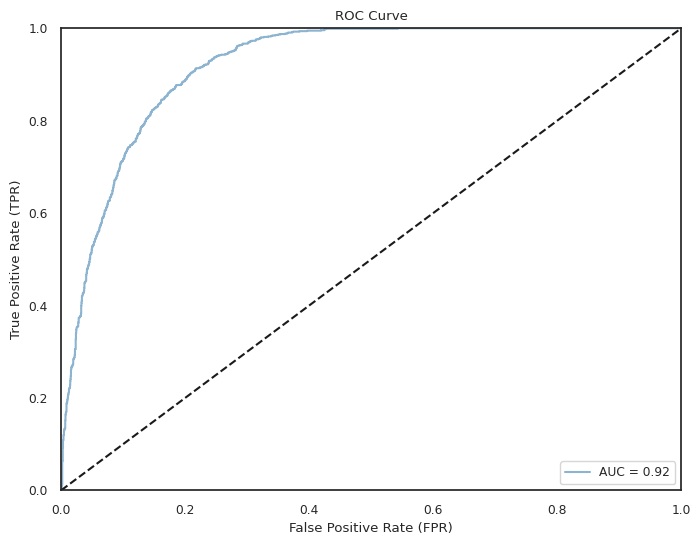

2025-05-13 21:47:08,559 - root - WARNING - /usr/local/lib/python3.11/dist-packages/bluecast/blueprints/cast.py:489: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


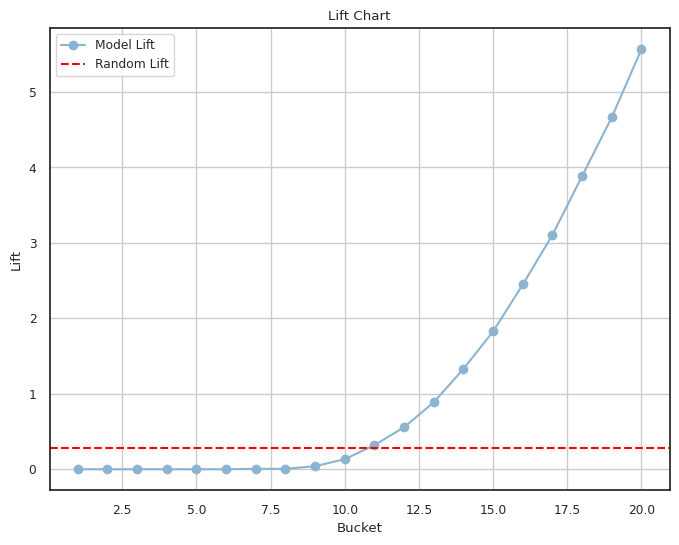

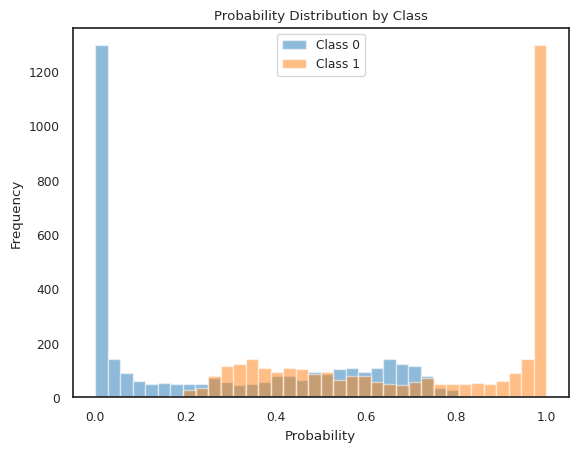

2025-05-13 21:47:09,315 - root - INFO - Start saving out of fold data.


{'matthews': 0.6235010142708188,
 'accuracy': 0.8454176334106729,
 'recall': 0.8454176334106729,
 'f1_score_macro': 0.8113638222879413,
 'f1_score_micro': 0.8454176334106729,
 'f1_score_weighted': 0.8468820635135617,
 'log_loss': 0.32296826052098154,
 'balanced_logloss': 0.40763336420059204,
 'roc_auc': 0.9203792788719185,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.90      0.88      0.89      2488\n           1       0.71      0.76      0.73       960\n\n    accuracy                           0.85      3448\n   macro avg       0.81      0.82      0.81      3448\nweighted avg       0.85      0.85      0.85      3448\n',
 'confusion_matrix': array([[2190,  298],
        [ 235,  725]])}

In [ ]:
automl.fit_eval(
    df=autoML_df,
    df_eval=autoML_df.drop('Healthy_Status', axis=1),
    target_eval=autoML_df['Healthy_Status'],
    target_col="Healthy_Status",
)

In [ ]:
y_probs, test_preds = automl.predict(auto_X_test)
cm = confusion_matrix(auto_Y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
roc_auc = roc_auc_score(auto_Y_test, test_preds)
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

2025-05-13 21:47:09,799 - root - INFO - Start casting feature types.
2025-05-13 21:47:09,804 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-05-13 21:47:09,805 - root - INFO - Dropped the following columns as constants only: [].
2025-05-13 21:47:09,805 - root - INFO - Start filling infinite values.
2025-05-13 21:47:09,806 - root - INFO - Start date column conversion (transform).
2025-05-13 21:47:09,807 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-05-13 21:47:09,809 - root - INFO - Start transforming categories with binary target encoder.
2025-05-13 21:47:09,812 - root - INFO - Start transforming categories with binary target encoder.
2025-05-13 21:47:09,817 - root - INFO - Predicting...
2025-05-13 21:47:09,821 - root - INFO - Start predicting on new data using Xgboost model.
2025-05-13 21:47:09,892 - root - INFO - Finished predicting


Confusion matrix: [[334  40]
 [ 35 109]]
F1-Score:  0.74
Accuracy: 0.86
Recall:  0.76
Precision:  0.73



AutoML Fedot

In [ ]:
!pip install -q scikit-learn==1.3.2
!pip install -q --user scipy>=1.2.0
!pip install fedot --quiet
from fedot.api.main import Fedot
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()
autoML_df = autoML_df.drop(columns='report')
random_seed = 13
clf_index = autoML_df.shape[1]-1
auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train
automl = BlueCast(class_problem="binary")
automl.fit(auto_train_df, target_col="Healthy_Status")
from data.data import get_train_data, get_test_data
train_features, train_target = get_train_data()
test_features, test_target = get_test_data()
fedot_model = Fedot(problem='classification', timeout=3)
obtained_pipeline = fedot_model.fit(features=auto_X, target=auto_Y)
obtained_pipeline.show()
predict = fedot_model.predict(auto_X_test)
predict_probs = fedot_model.predict_proba(auto_X_test)
plt.plot(predict_probs,'.')

2025-05-13 21:58:04,365 - root - INFO - BlueCast blueprint initialized.
2025-05-13 21:58:04,367 - root - INFO - Start detecting and casting feature types.
2025-05-13 21:58:04,375 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-05-13 21:58:04,376 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-05-13 21:58:04,384 - root - INFO - Dropped the following columns as constants only: [].
2025-05-13 21:58:04,386 - root - INFO - Dropped the following columns as constants only: [].
2025-05-13 21:58:04,651 - root - INFO - Start executing train-test split with train size of 0.8.
2025-05-13 21:58:04,675 - root - INFO - Start filling infinite values.
2025-05-13 21:58:04,679 - root - INFO - Start filling infinite values.
2025-05-13 21:58:04,682 - root - INFO - Start date column conversion.
2025-05-13 21:58:04,684 - root - INFO - Start date column conversion (transform).
2025-05-13 21:58:04,689 - root - INFO - Start fitting DataFrame schema.
2025-0

  0%|          | 0/200 [00:00<?, ?it/s]

[W 2025-05-13 22:04:27,140] Trial 20 failed with parameters: {'eta': 0.15378523685726042, 'max_depth': 5, 'alpha': 0.22283231606865556, 'lambda': 1.1185705897492653, 'gamma': 0.032102362187947146, 'min_child_weight': 7.699883282840204, 'subsample': 1.0, 'colsample_bytree': 0.9424110038451027, 'colsample_bylevel': 0.9824687270369437, 'steps': 1000, 'sample_weight': False, 'tree_method': 'approx', 'max_bin': 309, 'booster': 'gbtree', 'grow_policy': 'depthwise'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bluecast/ml_modelling/xgboost.py", line 361, in objective
    result = xgb.cv(
             ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/training.py", line 570, in cv
    booster.update(i, obj)
  File "/usr/local/

KeyboardInterrupt: 

In [ ]:
len(predict_probs)

In [ ]:
for i in range(len(predict_probs)):
  if predict_probs[i] > 0.5:
    predict_probs[i] = 1
  else:
    predict_probs[i] = 0
cm = confusion_matrix(auto_Y_test, predict_probs)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
roc_auc = roc_auc_score(auto_Y_test, predict_probs)
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))